In [1]:
from alphatools.research import run_pipeline, make_factor_plot
from alphatools.expression import ExpressionAlpha
from alphatools.ics import Sector
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline

In [2]:
universe = AverageDollarVolume(window_length=120).top(500)

In [3]:
expressions = {
    8:  '-1*rank(((sum(opens, 5)*sum(returns, 5))-delay((sum(opens, 5)*sum(returns, 5)),10)))', 
    53: '(-1*delta((((close-low) - (high-close)) / (close-low)), 9))',
    101: '((close - opens) / ((high - low) + .001))',
    102: 'scale((close > delay(close, 1)) ? opens : delay(opens, 1))',
    103: 'stddev(max(close, 20), 10)',
    104: 'product(1+returns, 20)',
    105: 'indneutralize(close, IndClass.subindustry)'
}


In [4]:
e = ExpressionAlpha(expressions[104])

In [5]:
e.parse()
print(e.tree.pretty())

product
  plus
    number	1
    returns
  20



In [6]:
e.transform()

<alphatools.expression.expression.ExpressionAlpha instance at 0x1c11c48e18>

In [7]:
max([1,2])


2

In [8]:
e.generate_pipeline_code()
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 22

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v0 = 1 + returns
        v1 = pd.DataFrame(data=v0).rolling(
            window=20, center=False, min_periods=1).apply(lambda x: np.prod(x)).values
        out[:] = v1[-1]



In [9]:
type(ExpressionAlpha(expressions[101]))

instance

In [10]:
one_o_one = (
    ExpressionAlpha(expressions[101]).
    make_pipeline_factor()
)

In [11]:
expr_factor = (
    ExpressionAlpha('rank(log(close/delay(close, 5)))').
    make_pipeline_factor().
    pipeline_factor(mask=universe)
)

In [12]:
p = Pipeline(screen=universe)
p.add(e.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha")
p.add(Sector(), "Sector")

start_date = '2017-01-06'
end_date = '2017-12-28'

df = run_pipeline(p, start_date, end_date)

In [14]:
df.head()

Expression Alpha  Sector
2017-01-06 00:00:00+00:00 Equity(0 [A])              1.040918       0
                          Equity(2 [AAL])            0.988370       2
                          Equity(7 [AAP])            0.992088       2
                          Equity(8 [AAPL])           1.060573       6
                          Equity(12 [ABBV])          1.034891       0

Formatting factor data for: Expression Alpha
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 5.19 secs
Time to generate long/short returns: 0.56 secs


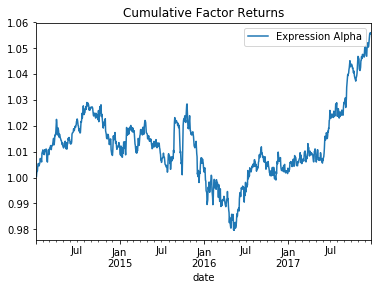

In [45]:
make_factor_plot(df, start_date, end_date);

In [15]:
e = ExpressionAlpha('rank(log(close/delay(opens, 5)))').parse().transform().generate_pipeline_code()

In [16]:
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 7

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v34 = np.roll(opens, 5)
        v35 = close / v34
        v36 = np.log(v35)
        v37 = np.apply_along_axis(rankdata, 1, v36)
        out[:] = v37[-1]



In [17]:
a

array([[ 0.77132064,  0.02075195],
       [ 0.63364823,  0.74880388],
       [ 0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071],
       [ 0.16911084,  0.08833981],
       [ 0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226],
       [ 0.81262096,  0.61252607],
       [ 0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578]])

In [18]:
b

array([[ 0.54254437,  0.14217005],
       [ 0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399],
       [ 0.61776698,  0.51313824],
       [ 0.65039718,  0.60103895],
       [ 0.8052232 ,  0.52164715],
       [ 0.90864888,  0.31923609],
       [ 0.09045935,  0.30070006],
       [ 0.11398436,  0.82868133],
       [ 0.04689632,  0.62628715]])

In [86]:
def column_corr((a, b), window=-1):
    if window==-1:
        window = a.shape[0]
    out = np.zeros(shape = (1, a.shape[1]))
    for i in xrange(a.shape[1]-1):
        out[i] = pearsonr(a[-window:, i], b[-window:, i])[0]
    return out
        

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(10)
a = np.random.random(30).reshape(10,3)
b = np.random.random(30).reshape(10,3)

In [15]:
def roll_corr((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

In [16]:
%%timeit
out = roll_corr((a,b), window=5)

1000 loops, best of 3: 645 µs per loop


In [17]:
a_1 = pd.DataFrame(a)
b_1 = pd.DataFrame(b)



In [23]:
%%timeit
out = pd.rolling_corr(arg1=a_1, arg2=b_1, window=5)

/anaconda3/envs/py27_clean/lib/python2.7/site-packages/ipykernel_launcher.py:257: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5).corr(other=<DataFrame>)


100 loops, best of 3: 10.1 ms per loop


In [21]:
out

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,0.441993,0.254435,0.707801
5,0.314446,0.233392,0.425191
6,0.243755,-0.441434,0.352801
7,0.281139,-0.864357,-0.192409
8,0.543645,-0.925822,-0.563786
9,0.445918,-0.784808,-0.532234


In [26]:

out = a_1.rolling(5,5).apply(lambda x: np.prod(x))

In [27]:
out

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,0.000040,0.002762,0.018662
5,0.000032,0.096057,0.008596
6,0.000039,0.137691,0.020747
7,0.000028,0.067592,0.082707
8,0.000139,0.042804,0.053591
9,0.018120,0.054353,0.039638


In [18]:
from numba import jit

In [19]:
@jit
def roll_corr2((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

ValueError: '.0' is not a valid parameter name

In [207]:
def scale(x):
    return (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x)))

In [211]:
np.apply_along_axis(lambda x: (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x))), 1, a)

array([[ 0.32572934, -0.5       ,  0.17427066],
       [ 0.4853247 ,  0.0146753 , -0.5       ],
       [-0.23118186,  0.5       , -0.26881814],
       [-0.5       ,  0.11250682,  0.38749318],
       [-0.5       ,  0.07890222,  0.42109778],
       [ 0.14084777,  0.35915223, -0.5       ],
       [ 0.5       , -0.02694105, -0.47305895],
       [-0.45819778, -0.04180222,  0.5       ],
       [-0.23369585, -0.26630415,  0.5       ],
       [-0.5       ,  0.41441077,  0.08558923]])

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [33]:
from __future__ import division

np.sum()

1.0

55

In [196]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(2)
a = np.random.random(30).reshape(10,3)    # days x stocks
b = np.random.randint(2, 5, size=(1,3))   # Industry cat vars as integers

In [197]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [198]:
b

array([[4, 2, 4]])

In [199]:
ohe = np.zeros((b.size, b.max()+1))
ohe[np.arange(b.size),b] = 1

In [191]:
ohe.T

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.]])

In [200]:
ind_mean = np.nan_to_num(a.dot(ohe)/ohe.sum(axis=0))

In [203]:
ind_mean

array([[ 0.        ,  0.        ,  0.02592623,  0.        ,  0.49282869],
       [ 0.        ,  0.        ,  0.4203678 ,  0.        ,  0.38282861],
       [ 0.        ,  0.        ,  0.61927097,  0.        ,  0.25215165],
       [ 0.        ,  0.        ,  0.62113383,  0.        ,  0.39798468],
       [ 0.        ,  0.        ,  0.51357812,  0.        ,  0.15950991],
       [ 0.        ,  0.        ,  0.85397529,  0.        ,  0.63978599],
       [ 0.        ,  0.        ,  0.07964548,  0.        ,  0.67590379],
       [ 0.        ,  0.        ,  0.42812233,  0.        ,  0.08090871],
       [ 0.        ,  0.        ,  0.59674531,  0.        ,  0.17658599],
       [ 0.        ,  0.        ,  0.22030621,  0.        ,  0.22838598]])

In [206]:
per_stock_ind_mean = ind_mean.dot(ohe.T)

In [207]:
per_stock_ind_mean # per stock ind_mean by day!

array([[ 0.49282869,  0.02592623,  0.49282869],
       [ 0.38282861,  0.4203678 ,  0.38282861],
       [ 0.25215165,  0.61927097,  0.25215165],
       [ 0.39798468,  0.62113383,  0.39798468],
       [ 0.15950991,  0.51357812,  0.15950991],
       [ 0.63978599,  0.85397529,  0.63978599],
       [ 0.67590379,  0.07964548,  0.67590379],
       [ 0.08090871,  0.42812233,  0.08090871],
       [ 0.17658599,  0.59674531,  0.17658599],
       [ 0.22838598,  0.22030621,  0.22838598]])